In [32]:
pip install lang2vec

Note: you may need to restart the kernel to use updated packages.


In [132]:
import lang2vec.lang2vec as l2v
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import re

In [154]:
avail_lang = l2v.available_languages()

#The Greenberg rules that will be later used as a reference
greenberg_rules = {
    "3": "Languages with dominant VSO order are always prepositional.",
    "4": "With overwhelmingly more than chance frequency, languages with normal SOV order are postpositional.",
    "5": "If a language has dominant SOV order and the genitive follows the governing noun, then the adjective likewise follows the noun.",
    "6": "All languages with dominant VSO order have the adjective after the noun.",
    "16": "If a language has dominant order VSO in declarative sentences, it always puts prepositions before the noun.",
    "17": "With overwhelmingly more than chance frequency, languages with dominant order SOV are postpositional.",
    "18": "When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.",
    "19": "When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.",
    "20": "When any or all of the modifiers precede the noun, the genitive almost always precedes.",
    "21": "When any or all of the modifiers follow the noun, the genitive almost always follows.",
    "22": "If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositional.",
    "23": "If in a language the verb precedes the object, the adjective likewise precedes the noun.",
    "24": "If in a language the verb follows the object, the adjective likewise follows the noun.",
    "25": "If a language has dominant order VSO, it always has prepositions.",
    "26": "If a language has dominant order SOV, it generally has postpositions.",
    "41": "If in a language the verb follows both the nominal subject and nominal object as the dominant order, the language almost always has a case system."
}

avail_lang_list = []
for lang in avail_lang:
    avail_lang_list.append(str(lang))

# iso_code -> feature_vector
features_dict = l2v.get_features(avail_lang_list, "syntax_wals", header=True)

# extract feature names
feature_names = features_dict["CODE"]

# build a matrix for all languages
# missing values are encoded as the string '--'
rows = []
valid_langs = []

for lang in avail_lang_list:
    if lang not in features_dict:
        print(f"[warning] language {lang} not available, skipping.")
        continue
    rows.append(features_dict[lang])
    valid_langs.append(lang)

# each row is a language, each column is a wals feature
all_syntax_features_df = pd.DataFrame(rows, index=valid_langs, columns=feature_names)

# replace the missing marker '--' with np.nan so pandas can handle it
all_syntax_features_df = all_syntax_features_df.replace("--", np.nan)

print("shape:", all_syntax_features_df.shape)
display(all_syntax_features_df.tail())

shape: (4005, 103)


/tmp/ipykernel_95/1795449748.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_syntax_features_df = all_syntax_features_df.replace("--", np.nan)


,S_SVO,S_SOV,S_VSO,S_VOS,S_OVS,S_OSV,S_SUBJECT_BEFORE_VERB,S_SUBJECT_AFTER_VERB,S_OBJECT_AFTER_VERB,S_OBJECT_BEFORE_VERB,...,S_XVO,S_XOV,S_OXV,S_OVX,S_OBLIQUE_AFTER_VERB,S_OBLIQUE_AFTER_OBJECT,S_OBLIQUE_BEFORE_VERB,S_OBLIQUE_BEFORE_OBJECT,S_ARTICLE_WORD_BEFORE_NOUN,S_ARTICLE_WORD_AFTER_NOUN
mzp,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nri,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rif,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
bnp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
def select_cols(df, keywords):
    return [c for c in df.columns if any(k in c for k in keywords)]

cols_49A = select_cols(all_syntax_features_df, ["CASE", "CASES"]) # 49A number of cases
cols_50A = select_cols(all_syntax_features_df, ["ASYMMETRIC"]) # 50A asymmetrical case marking
cols_81A = select_cols(all_syntax_features_df, ["SVO", "SOV", "VSO", "VOS", "OVS", "OSV"]) # 81A basic order
cols_85A = select_cols(all_syntax_features_df, ["ADPOSITION", "ADP"]) # 85A adposition + np
cols_86A = select_cols(all_syntax_features_df, ["POSSESSOR"]) # 86A genitive + noun  CHANGED FROM GENETIVE
cols_87A = select_cols(all_syntax_features_df, ["ADJECTIVE"]) # 87A adjective + noun
cols_88A = select_cols(all_syntax_features_df, ["DEMONSTRATIVE"]) # 88A demonstrative + noun
cols_89A = select_cols(all_syntax_features_df, ["NUMERAL"]) # 89A numeral + noun
cols_90A = select_cols(all_syntax_features_df, ["RELATIVE"]) # 90A relative clause + noun

# flatten everything into one list of interesting columns
interesting_cols = (
    cols_49A + cols_50A + cols_81A +
    cols_85A + cols_86A + cols_87A +
    cols_88A + cols_89A + cols_90A
)

# keep only these columns in a new dataframe
focus_syntax_features_df = all_syntax_features_df[interesting_cols].copy()

print("shape (focused on 49A, 50A, 81A, 85A–90A):", focus_syntax_features_df.shape)
non_na_features = focus_syntax_features_df[focus_syntax_features_df.notna().any(axis=1)] # Removing the rows where all the value for all attributes is NaN
display(non_na_features.tail())

shape (focused on 49A, 50A, 81A, 85A–90A): (4005, 30)


,S_CASE_PREFIX,S_CASE_SUFFIX,S_CASE_PROCLITIC,S_CASE_ENCLITIC,S_CASE_MARK,S_SVO,S_SOV,S_VSO,S_VOS,S_OVS,...,S_ANY_AGREEMENT_ON_ADJECTIVES,S_DEMONSTRATIVE_WORD_BEFORE_NOUN,S_DEMONSTRATIVE_WORD_AFTER_NOUN,S_DEMONSTRATIVE_PREFIX,S_DEMONSTRATIVE_SUFFIX,S_NUMERAL_BEFORE_NOUN,S_NUMERAL_AFTER_NOUN,S_RELATIVE_BEFORE_NOUN,S_RELATIVE_AFTER_NOUN,S_RELATIVE_AROUND_NOUN
khm,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
kwn,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
mzp,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nri,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
rif,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [95]:
def rule_based (lang_data):
    '''
    Classification different attributes based on the rules of Greenberg
    '''
    
    attributes = {}

    attributes["RULE_BASED_PRED"] = 1
    
    if lang_data.S_VSO == 1:
        attributes["S_ADPOSITION_BEFORE_NOUN"] = 1 # RULE 3, RULE 25
        attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 6

    if lang_data.S_SOV == 1:
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 4, RULE 26
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 17
        if lang_data.S_POSSESSOR_AFTER_NOUN == 1: 
            attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 5
        
    if lang_data.S_ADJECTIVE_BEFORE_NOUN == 1:
        attributes["S_DEMONSTRATIVE_WORD_BEFORE_NOUN"] = 1 # RULE 18
        attributes["S_NUMERAL_BEFORE_NOUN"] = 1 # RULE 18

    if lang_data.S_ADJECTIVE_AFTER_NOUN == 1:
        attributes["S_DEMONSTRATIVE_WORD_AFTER_NOUN"] = 1 # RULE 19
        attributes["S_NUMERAL_AFTER_NOUN"] = 1 # RULE 19

    if (lang_data.S_ADJECTIVE_BEFORE_NOUN == 1 or lang_data.S_DEMONSTRATIVE_WORD_BEFORE_NOUN == 1 or lang_data.S_NUMERAL_BEFORE_NOUN == 1):
        attributes["S_POSSESSOR_BEFORE_NOUN"] = 1 # RULE 20

    if (lang_data.S_ADJECTIVE_AFTER_NOUN == 1 or lang_data.S_DEMONSTRATIVE_WORD_AFTER_NOUN == 1 or lang_data.S_NUMERAL_AFTER_NOUN == 1):
        attributes["S_POSSESSOR_BEFORE_NOUN"] = 1 # RULE 21

    if lang_data.S_RELATIVE_BEFORE_NOUN == 1:
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 22
    if lang_data.S_RELATIVE_AFTER_NOUN == 1:
        attributes["S_ADPOSITION_BEFORE_NOUN"] = 1 # RULE 22

    if (lang_data.S_SVO == 1 or lang_data.S_VSO == 1 or lang_data.S_VOS == 1):
        attributes["S_ADJECTIVE_BEFORE_NOUN"] = 1 # RULE 23

    if (lang_data.S_SOV == 1 or lang_data.S_OVS == 1 or lang_data.S_OSV == 1):
        attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 24

    if (lang_data.S_SOV == 1 or lang_data.S_OSV == 1):
        attributes["HAS_CASE_SYSTEM"] = 1 # RULE 41. NEEDS TO BE EVALUATED DIFFERENTLY

    
    return attributes

    """
    NOT IMPLEMENTED
    RULE 16: If a language has dominant order VSO in declarative sentences, it always puts prepositions before the noun.

    """
    

In [96]:
rule_based_predictions = {}

for lang in non_na_features.index:
    preds = rule_based(non_na_features.loc[lang]) # Predict some attributes for each language
    rule_based_predictions[non_na_features.loc[lang].name] = preds #Create a row in the dictionary with the predictions for that language

rule_based_pred_df = pd.DataFrame.from_dict(rule_based_predictions, orient="index") # Convert the dictionary to a dataframe 

In [170]:
def pred_eval(pred_df, ground_truth_df): 
    '''
    Evaluate the predictions of the rule based classifier with the ground truth
    '''
    # Columns that could have been predicted
    relevant_cols = [
        'S_DEMONSTRATIVE_WORD_AFTER_NOUN', 'S_NUMERAL_AFTER_NOUN', 'S_POSSESSOR_BEFORE_NOUN', 'S_ADPOSITION_BEFORE_NOUN', 
        'S_ADJECTIVE_AFTER_NOUN', 'S_ADJECTIVE_BEFORE_NOUN', 'S_DEMONSTRATIVE_WORD_BEFORE_NOUN', 'S_NUMERAL_BEFORE_NOUN',
        'S_ADPOSITION_AFTER_NOUN', 'HAS_CASE_SYSTEM'
    ] 
    
    ground_truth_df_converted = ground_truth_df.copy()
    ground_truth_df_converted["HAS_CASE_SYSTEM"] = np.where(
            (ground_truth_df_converted["S_CASE_PREFIX"] > 0) | 
            (ground_truth_df_converted["S_CASE_SUFFIX"] > 0) |
            (ground_truth_df_converted["S_CASE_PROCLITIC"] > 0) |
            (ground_truth_df_converted["S_CASE_ENCLITIC"] > 0) |
            (ground_truth_df_converted["S_CASE_MARK"] > 0) 
            , 1, 0) # Since HAS_CASE_SYSTEM isn't a feature in the WALS dataset, we create on based on any of the case features having a value

    ground_truth_df_converted_rel = ground_truth_df_converted[relevant_cols].copy()
    pred_df_rel = pred_df[relevant_cols].copy()

    comparison_df = ground_truth_df_converted_rel.join(pred_df_rel, how='outer', lsuffix='_truth', rsuffix='_pred') # Joining the two datasets for easy comparison

    pred_results = {}
    
    for col in relevant_cols:
        total = len(comparison_df.index)
        # The rows where either there was either no prediciton made or the ground truth is missing are counted as incomparable
        incomparable = len(comparison_df[(pd.isna(comparison_df[col + "_truth"]))| (pd.isna(comparison_df[col + "_pred"]))].index)
        tp = len(comparison_df[(comparison_df[col + "_truth"] == 1) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        fp = len(comparison_df[(comparison_df[col + "_pred"] == 1) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        correct = len(comparison_df[(comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        tn = len(comparison_df[(comparison_df[col + "_truth"] == 0) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        fn = len(comparison_df[(comparison_df[col + "_pred"] == 0) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        incorrect = len(comparison_df[(comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)

        pred_results[col] = {"total languages": total, "incomparable": incomparable, "correct": correct, "incorrect": incorrect, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

    return pred_results

In [172]:


results_rule_based_comp = pred_eval(rule_based_pred_df, non_na_features)
results_rule_based_comp_df = pd.DataFrame.from_dict(results_rule_based_comp, orient="index")
#Mapping the predictions too which rules they could have steamed from
results_rule_based_comp_df["Rule mapping"] = "NA"
results_rule_based_comp_df["Rule mapping"] = np.where((results_rule_based_comp_df.index == "S_DEMONSTRATIVE_WORD_AFTER_NOUN") | (results_rule_based_comp_df.index == "S_NUMERAL_AFTER_NOUN"), "19", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_POSSESSOR_BEFORE_NOUN", "20, 21", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADPOSITION_BEFORE_NOUN", "3, 25, 22", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADJECTIVE_AFTER_NOUN", "5, 6, 24", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADJECTIVE_BEFORE_NOUN", "23", results_rule_based_comp_df["Rule mapping"])
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_DEMONSTRATIVE_WORD_BEFORE_NOUN", "18", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_NUMERAL_BEFORE_NOUN", "18", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADPOSITION_AFTER_NOUN", "4, 17, 22, 26", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "HAS_CASE_SYSTEM", "41", results_rule_based_comp_df["Rule mapping"]) 

results_rule_based_comp_df["accuracy"] = round(results_rule_based_comp_df["correct"]/(results_rule_based_comp_df["correct"] + results_rule_based_comp_df["incorrect"]),2)


results_rule_based_comp_df = results_rule_based_comp_df.sort_values(by=["accuracy"], ascending=False)


results_rule_based_comp_df

,total languages,incomparable,correct,incorrect,tp,fp,tn,fn,Rule mapping,accuracy
S_ADPOSITION_AFTER_NOUN,1560,1102,429,29,429,29,0,0,"4, 17, 22, 26",0.94
S_DEMONSTRATIVE_WORD_BEFORE_NOUN,1560,1197,317,46,317,46,0,0,18,0.87
S_NUMERAL_BEFORE_NOUN,1560,1198,305,57,305,57,0,0,18,0.84
S_NUMERAL_AFTER_NOUN,1560,799,563,198,563,198,0,0,19,0.74
S_ADPOSITION_BEFORE_NOUN,1560,1003,411,146,411,146,0,0,"3, 25, 22",0.74
S_DEMONSTRATIVE_WORD_AFTER_NOUN,1560,814,492,254,492,254,0,0,19,0.66
S_ADJECTIVE_AFTER_NOUN,1560,956,391,213,391,213,0,0,"5, 6, 24",0.65
S_POSSESSOR_BEFORE_NOUN,1560,387,725,448,725,448,0,0,"20, 21",0.62
HAS_CASE_SYSTEM,1560,984,325,251,325,251,0,0,41,0.56
S_ADJECTIVE_BEFORE_NOUN,1560,966,146,448,146,448,0,0,23,0.25


In [122]:
def train_deci_tree_with_grid(df, target_attribute):
    
    param_grid = {
      'criterion': ["entropy"],
      'min_samples_split': range(2,10,1),
      "max_depth": range(1,2,1)

    }

    if target_attribute == "HAS_CASE_SYSTEM":
        target_name = "CASE"
    else:
        target_name = re.search(r"S_([^_]+)", target_attribute).group(1)
    x = df.loc[:, (df.columns != target_attribute) & ~(df.columns.str.contains(target_name, regex= True, na=False))] # Exclude attributes related to the target 
    y = df[target_attribute]
    
    tree = DecisionTreeClassifier(random_state=1)
    
    cv_strategy = KFold(
    n_splits=5,
    shuffle=True,
    random_state=1
    )
    
    grid_search = GridSearchCV(
      estimator=tree,
      param_grid=param_grid,
      cv=cv_strategy,
      refit="Accuracy",
      verbose=True
    )
    
    grid_search.fit(x,y)
    
    return grid_search.best_estimator_, x

In [176]:
def pred_eval_decision_tree(pred_df, ground_truth_df, col): 
    
    ground_truth_df_converted = ground_truth_df.copy()

    ground_truth_df_converted_rel = ground_truth_df_converted[col].copy()
    pred_df_rel = pred_df[col].copy()

    comparison_df = ground_truth_df_converted_rel.to_frame().join(pred_df_rel.to_frame(), how='outer', lsuffix='_truth', rsuffix='_pred')

    pred_results = {}
    
    total = len(comparison_df.index)
    incomparable = len(comparison_df[(pd.isna(comparison_df[col + "_truth"]))| (pd.isna(comparison_df[col + "_pred"]))].index)
    tp = len(comparison_df[(comparison_df[col + "_truth"] == 1) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    fp = len(comparison_df[(comparison_df[col + "_pred"] == 1) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)    
    correct = len(comparison_df[(comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    tn = len(comparison_df[(comparison_df[col + "_truth"] == 0) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    fn = len(comparison_df[(comparison_df[col + "_pred"] == 0) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)    
    incorrect = len(comparison_df[(comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)

    pred_results[col] = {"total languages": total, "incomparable": incomparable, "correct": correct, "incorrect": incorrect, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

    return pred_results

In [177]:
relevant_cols = [
    'S_DEMONSTRATIVE_WORD_AFTER_NOUN', 'S_NUMERAL_AFTER_NOUN', 'S_POSSESSOR_BEFORE_NOUN', 'S_ADPOSITION_BEFORE_NOUN', 
    'S_ADJECTIVE_AFTER_NOUN', 'S_ADJECTIVE_BEFORE_NOUN', 'S_DEMONSTRATIVE_WORD_BEFORE_NOUN', 'S_NUMERAL_BEFORE_NOUN',
    'S_ADPOSITION_AFTER_NOUN', 'HAS_CASE_SYSTEM'
]

results_decision_tree_comp = []
models = {}
x_attributes = {}

for col in relevant_cols:
    if col != "HAS_CASE_SYSTEM":
        non_na_y_features = non_na_features[pd.notna(non_na_features[col])]
    elif col == "HAS_CASE_SYSTEM":
        non_na_y_features = non_na_features.copy()
        non_na_y_features["HAS_CASE_SYSTEM"] = np.where(
        (non_na_y_features["S_CASE_PREFIX"] > 0) | 
        (non_na_y_features["S_CASE_SUFFIX"] > 0) |
        (non_na_y_features["S_CASE_PROCLITIC"] > 0) |
        (non_na_y_features["S_CASE_ENCLITIC"] > 0) |
        (non_na_y_features["S_CASE_MARK"] > 0) 
        , 1, 0) 
        non_na_y_features = non_na_y_features.drop(columns=["S_CASE_PREFIX", "S_CASE_SUFFIX","S_CASE_PROCLITIC","S_CASE_ENCLITIC","S_CASE_MARK"])
        
    models[col], x = train_deci_tree_with_grid(non_na_y_features, col)
    x_attributes[col] = x.columns
    
    pred = models[col].predict(x)

    decision_tree_pred_df = pd.DataFrame()
    decision_tree_pred_df.index = non_na_y_features.index
    decision_tree_pred_df[col] = pred.tolist()

    results_decision_tree_comp.append(pred_eval_decision_tree(decision_tree_pred_df, non_na_y_features, col))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [179]:
results_decision_tree_comp_df = pd.DataFrame.from_dict(
    {list(d.keys())[0]: list(d.values())[0] for d in results_decision_tree_comp},
    orient="index"
)
results_decision_tree_comp_df["accuracy"] = round((results_decision_tree_comp_df["tp"] + results_decision_tree_comp_df["tn"])/(results_decision_tree_comp_df["tp"] + results_decision_tree_comp_df["fp"] + results_decision_tree_comp_df["tn"] + results_decision_tree_comp_df["fn"]),2)
results_decision_tree_comp_df

,total languages,incomparable,correct,incorrect,tp,fp,tn,fn,accuracy
S_DEMONSTRATIVE_WORD_AFTER_NOUN,1126,0,825,301,511,252,314,49,0.73
S_NUMERAL_AFTER_NOUN,1124,0,854,270,607,222,247,48,0.76
S_POSSESSOR_BEFORE_NOUN,1216,0,917,299,470,16,447,283,0.75
S_ADPOSITION_BEFORE_NOUN,1144,0,985,159,460,57,525,102,0.86
S_ADJECTIVE_AFTER_NOUN,1314,0,952,362,952,362,0,0,0.72
S_ADJECTIVE_BEFORE_NOUN,1314,0,907,407,418,361,489,46,0.69
S_DEMONSTRATIVE_WORD_BEFORE_NOUN,1126,0,852,274,317,46,535,228,0.76
S_NUMERAL_BEFORE_NOUN,1124,0,839,285,305,57,534,228,0.75
S_ADPOSITION_AFTER_NOUN,1144,0,968,176,531,96,437,80,0.85
HAS_CASE_SYSTEM,1560,0,994,566,476,436,518,130,0.64


Decision tree for predicting S_DEMONSTRATIVE_WORD_AFTER_NOUN
Results of the rule
total languages    1126.00
incomparable          0.00
correct             825.00
incorrect           301.00
tp                  511.00
fp                  252.00
tn                  314.00
fn                   49.00
accuracy              0.73
Name: S_DEMONSTRATIVE_WORD_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.73 / 0.66
Related Greenberg rules
Rule 19: When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.


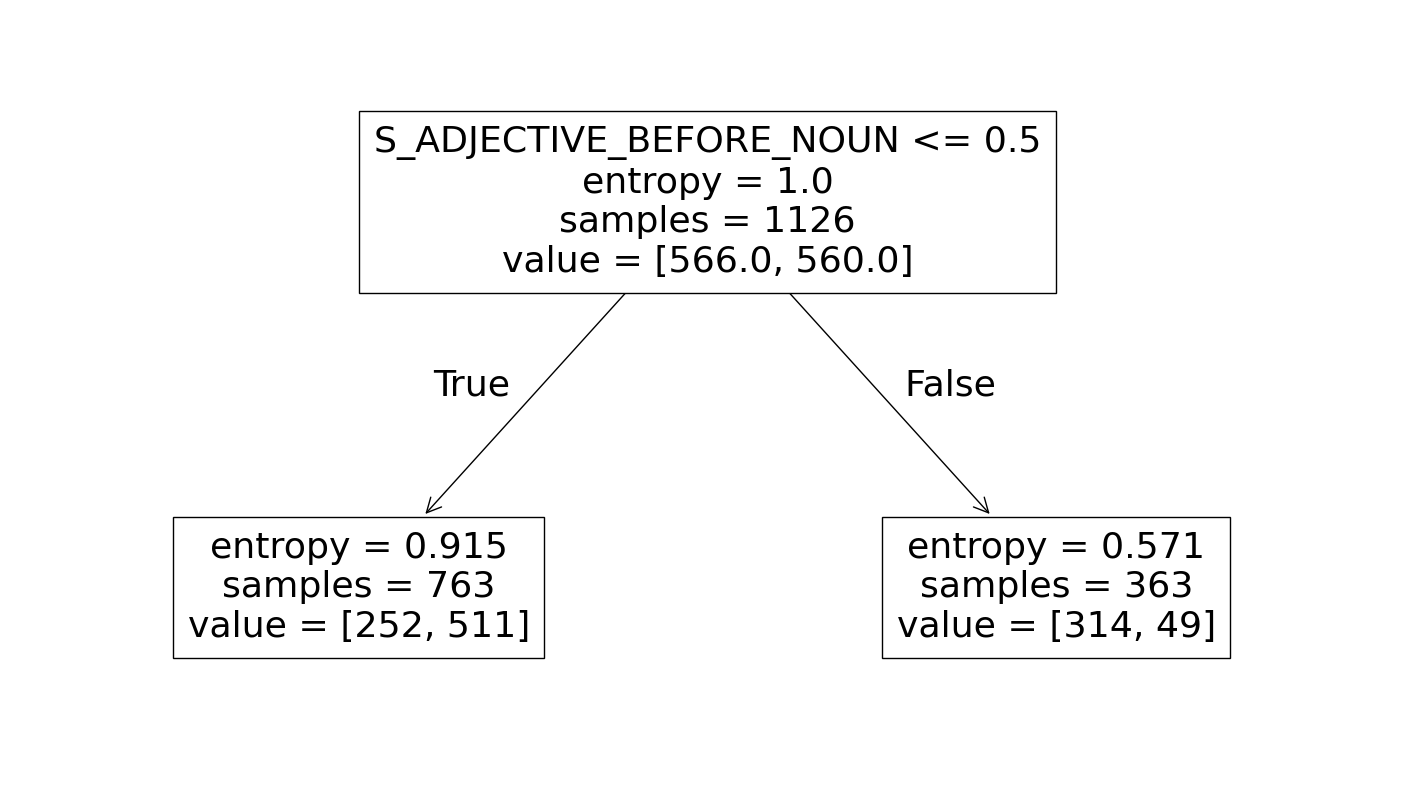

Decision tree for predicting S_NUMERAL_AFTER_NOUN
Results of the rule
total languages    1124.00
incomparable          0.00
correct             854.00
incorrect           270.00
tp                  607.00
fp                  222.00
tn                  247.00
fn                   48.00
accuracy              0.76
Name: S_NUMERAL_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.76 / 0.74
Related Greenberg rules
Rule 19: When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.


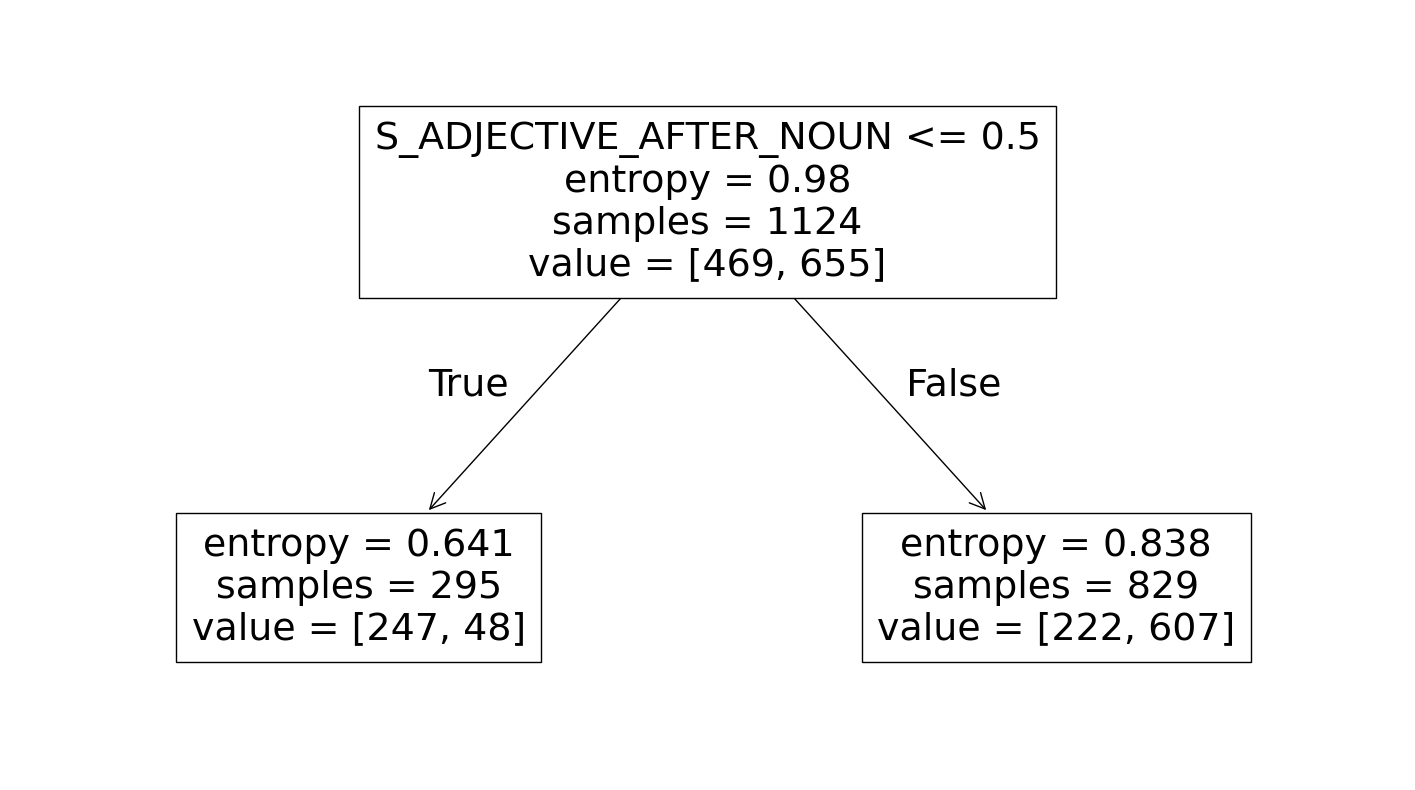

Decision tree for predicting S_POSSESSOR_BEFORE_NOUN
Results of the rule
total languages    1216.00
incomparable          0.00
correct             917.00
incorrect           299.00
tp                  470.00
fp                   16.00
tn                  447.00
fn                  283.00
accuracy              0.75
Name: S_POSSESSOR_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.75 / 0.62
Related Greenberg rules
Rule 20: When any or all of the modifiers precede the noun, the genitive almost always precedes.
Rule  21: When any or all of the modifiers follow the noun, the genitive almost always follows.


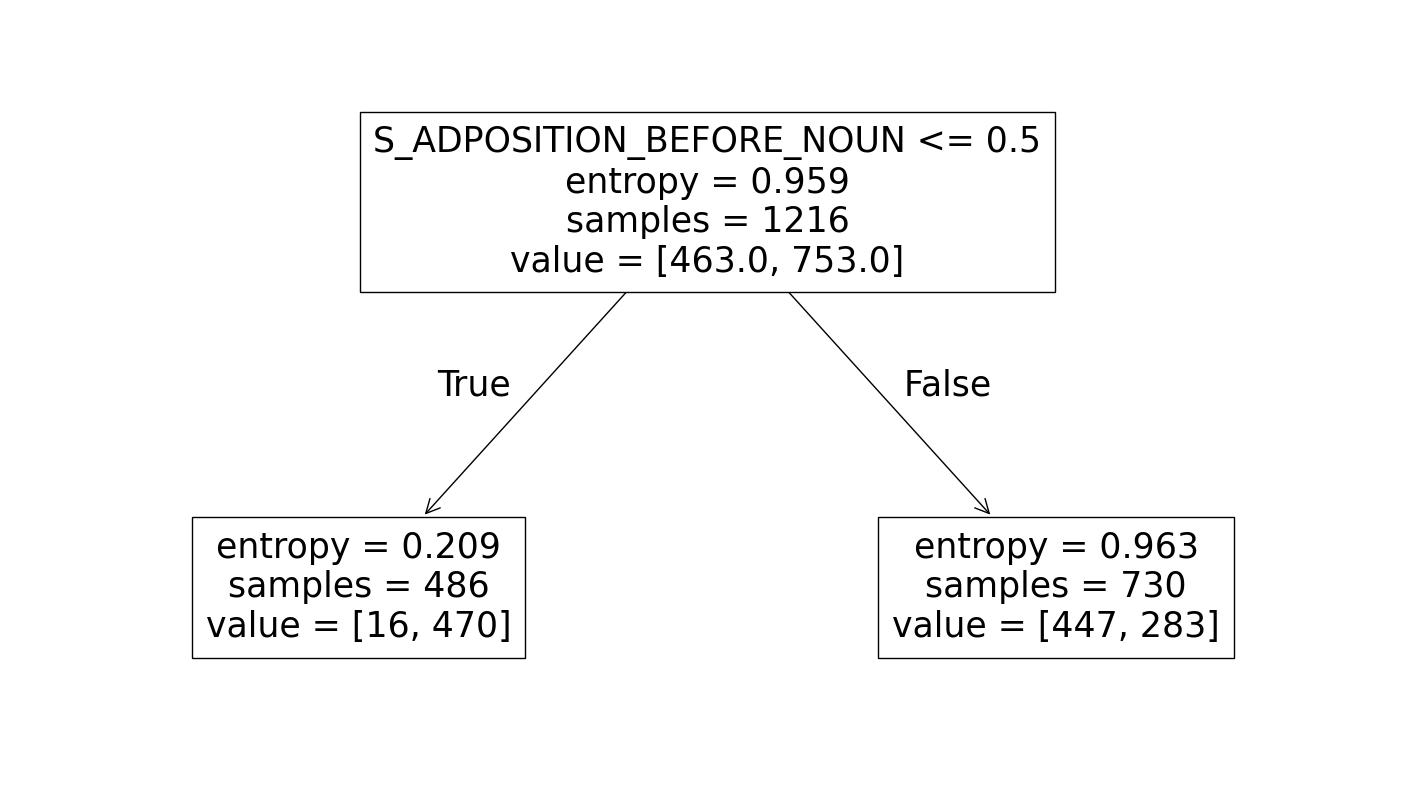

Decision tree for predicting S_ADPOSITION_BEFORE_NOUN
Results of the rule
total languages    1144.00
incomparable          0.00
correct             985.00
incorrect           159.00
tp                  460.00
fp                   57.00
tn                  525.00
fn                  102.00
accuracy              0.86
Name: S_ADPOSITION_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.86 / 0.74
Related Greenberg rules
Rule 3: Languages with dominant VSO order are always prepositional.
Rule  25: If a language has dominant order VSO, it always has prepositions.
Rule  22: If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositional.


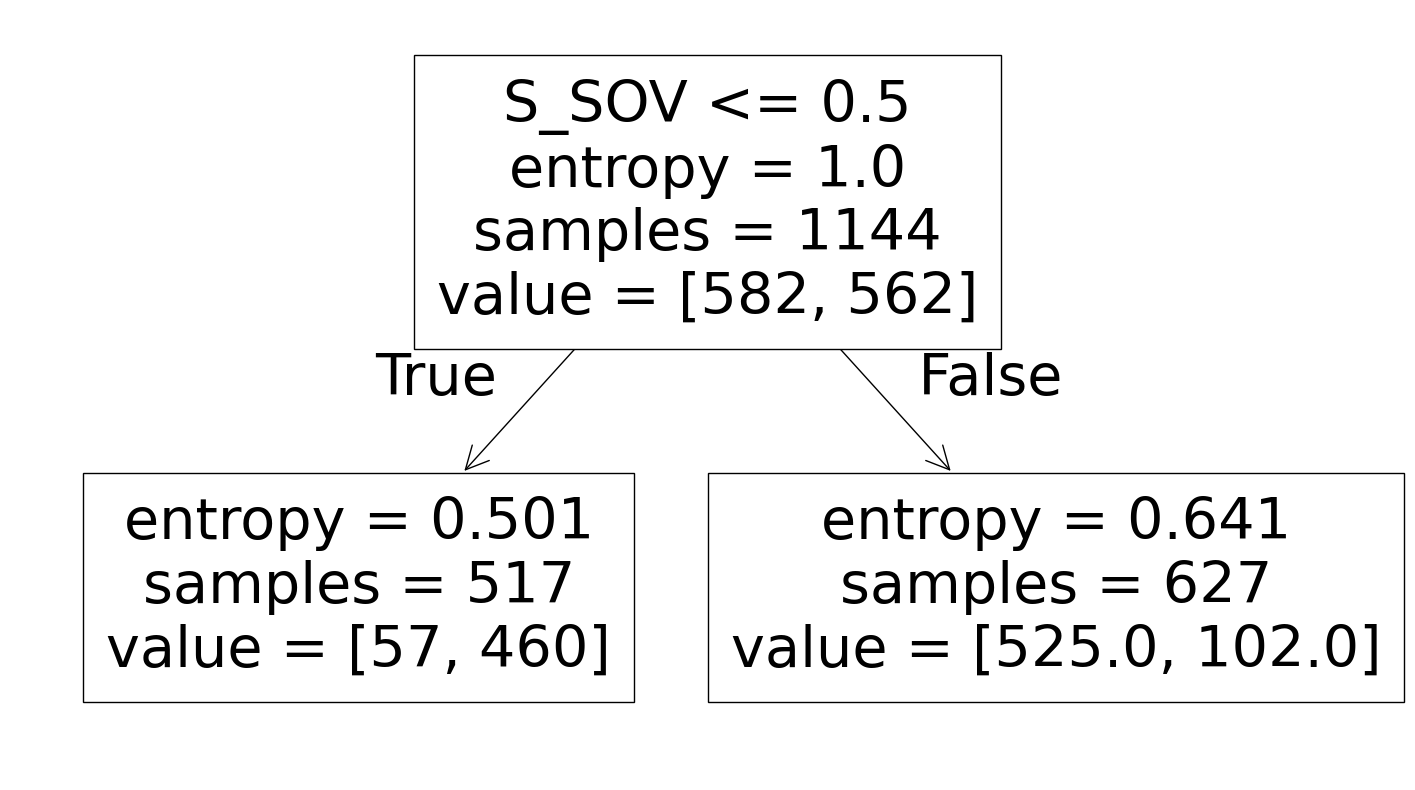

Decision tree for predicting S_ADJECTIVE_AFTER_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct             952.00
incorrect           362.00
tp                  952.00
fp                  362.00
tn                    0.00
fn                    0.00
accuracy              0.72
Name: S_ADJECTIVE_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.72 / 0.65
Related Greenberg rules
Rule 5: If a language has dominant SOV order and the genitive follows the governing noun, then the adjective likewise follows the noun.
Rule  6: All languages with dominant VSO order have the adjective after the noun.
Rule  24: If in a language the verb follows the object, the adjective likewise follows the noun.


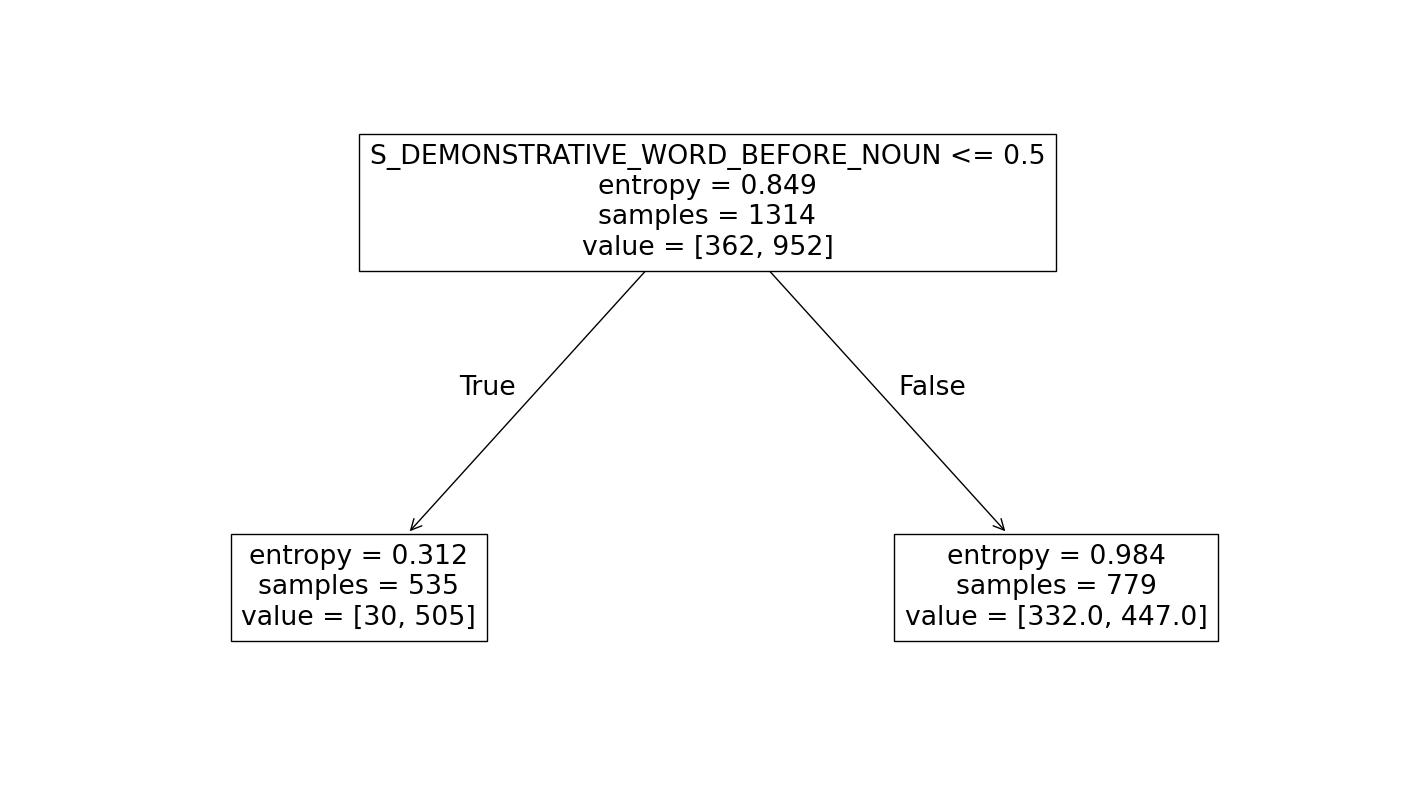

Decision tree for predicting S_ADJECTIVE_BEFORE_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct             907.00
incorrect           407.00
tp                  418.00
fp                  361.00
tn                  489.00
fn                   46.00
accuracy              0.69
Name: S_ADJECTIVE_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.69 / 0.25
Related Greenberg rules
Rule 23: If in a language the verb precedes the object, the adjective likewise precedes the noun.


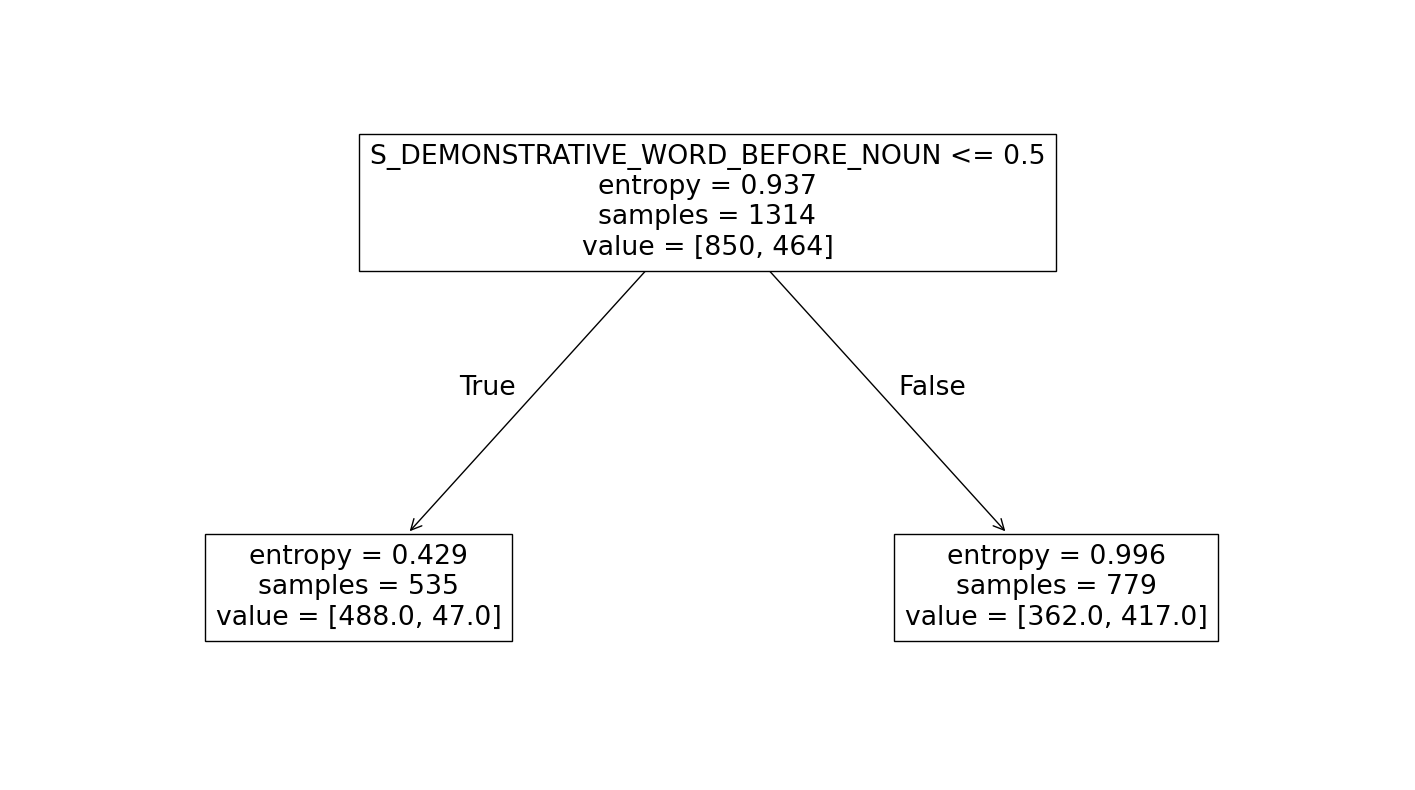

Decision tree for predicting S_DEMONSTRATIVE_WORD_BEFORE_NOUN
Results of the rule
total languages    1126.00
incomparable          0.00
correct             852.00
incorrect           274.00
tp                  317.00
fp                   46.00
tn                  535.00
fn                  228.00
accuracy              0.76
Name: S_DEMONSTRATIVE_WORD_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.76 / 0.87
Related Greenberg rules
Rule 18: When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.


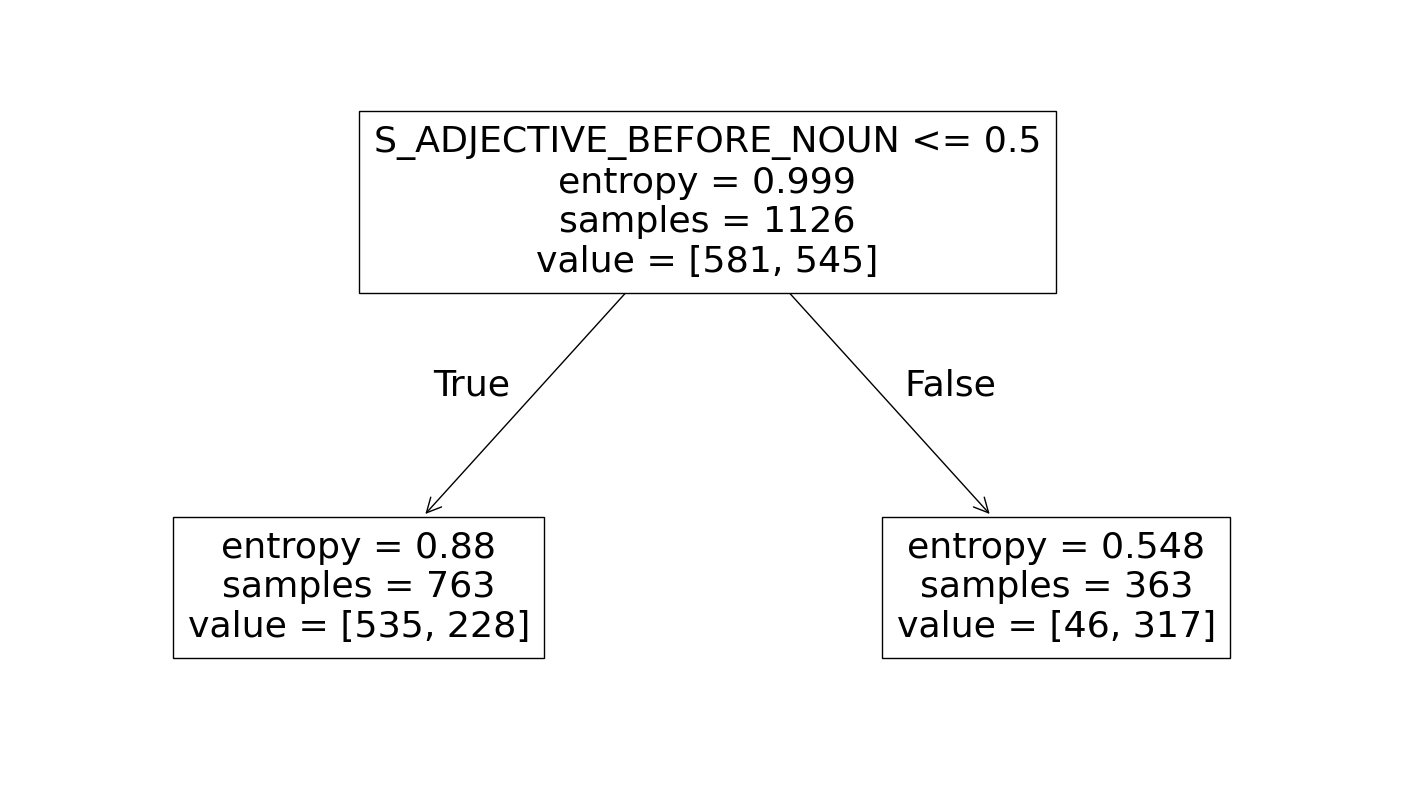

Decision tree for predicting S_NUMERAL_BEFORE_NOUN
Results of the rule
total languages    1124.00
incomparable          0.00
correct             839.00
incorrect           285.00
tp                  305.00
fp                   57.00
tn                  534.00
fn                  228.00
accuracy              0.75
Name: S_NUMERAL_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.75 / 0.84
Related Greenberg rules
Rule 18: When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.


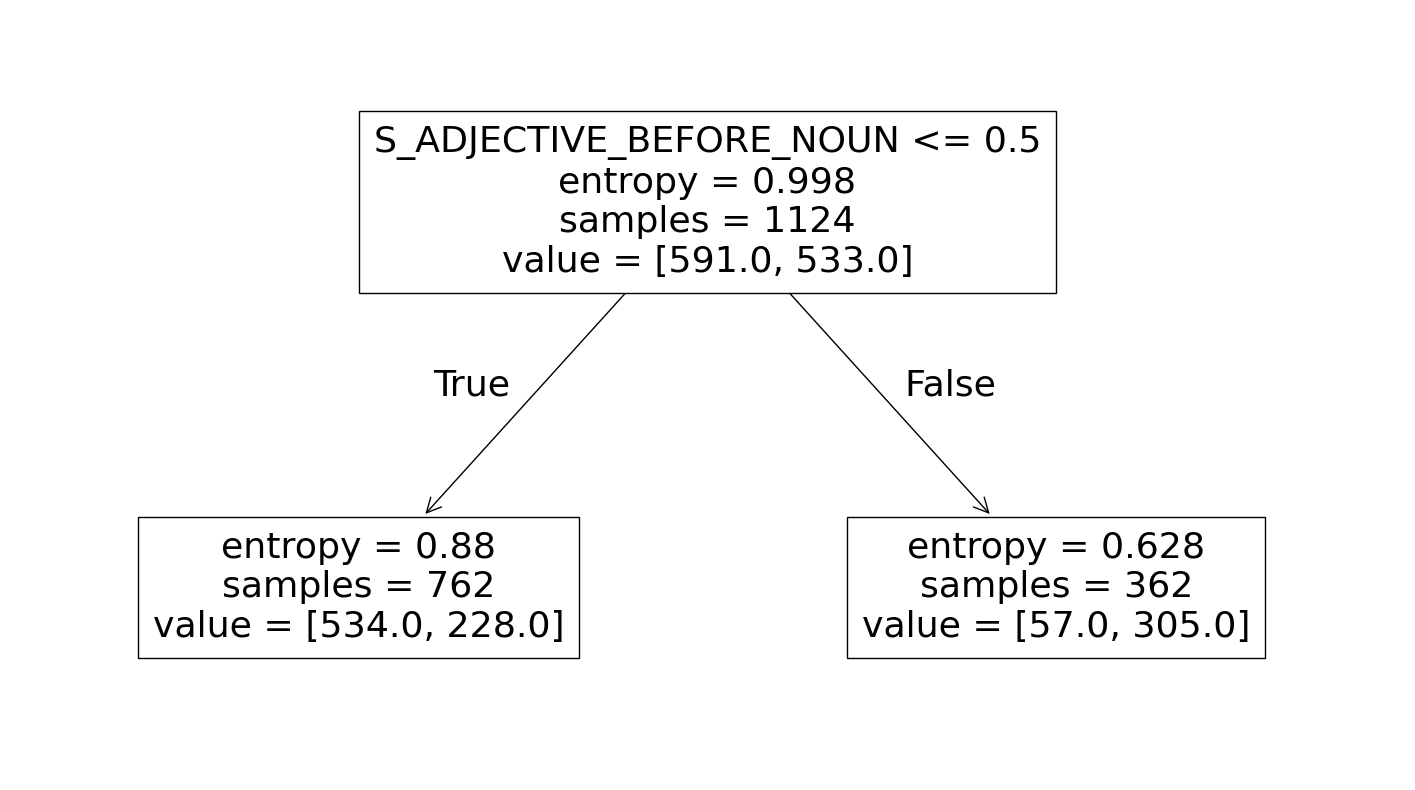

Decision tree for predicting S_ADPOSITION_AFTER_NOUN
Results of the rule
total languages    1144.00
incomparable          0.00
correct             968.00
incorrect           176.00
tp                  531.00
fp                   96.00
tn                  437.00
fn                   80.00
accuracy              0.85
Name: S_ADPOSITION_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.85 / 0.94
Related Greenberg rules
Rule 4: With overwhelmingly more than chance frequency, languages with normal SOV order are postpositional.
Rule  17: With overwhelmingly more than chance frequency, languages with dominant order SOV are postpositional.
Rule  22: If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositional.
Rule  26: If a language has dominant order SOV, it generally has postpositions.


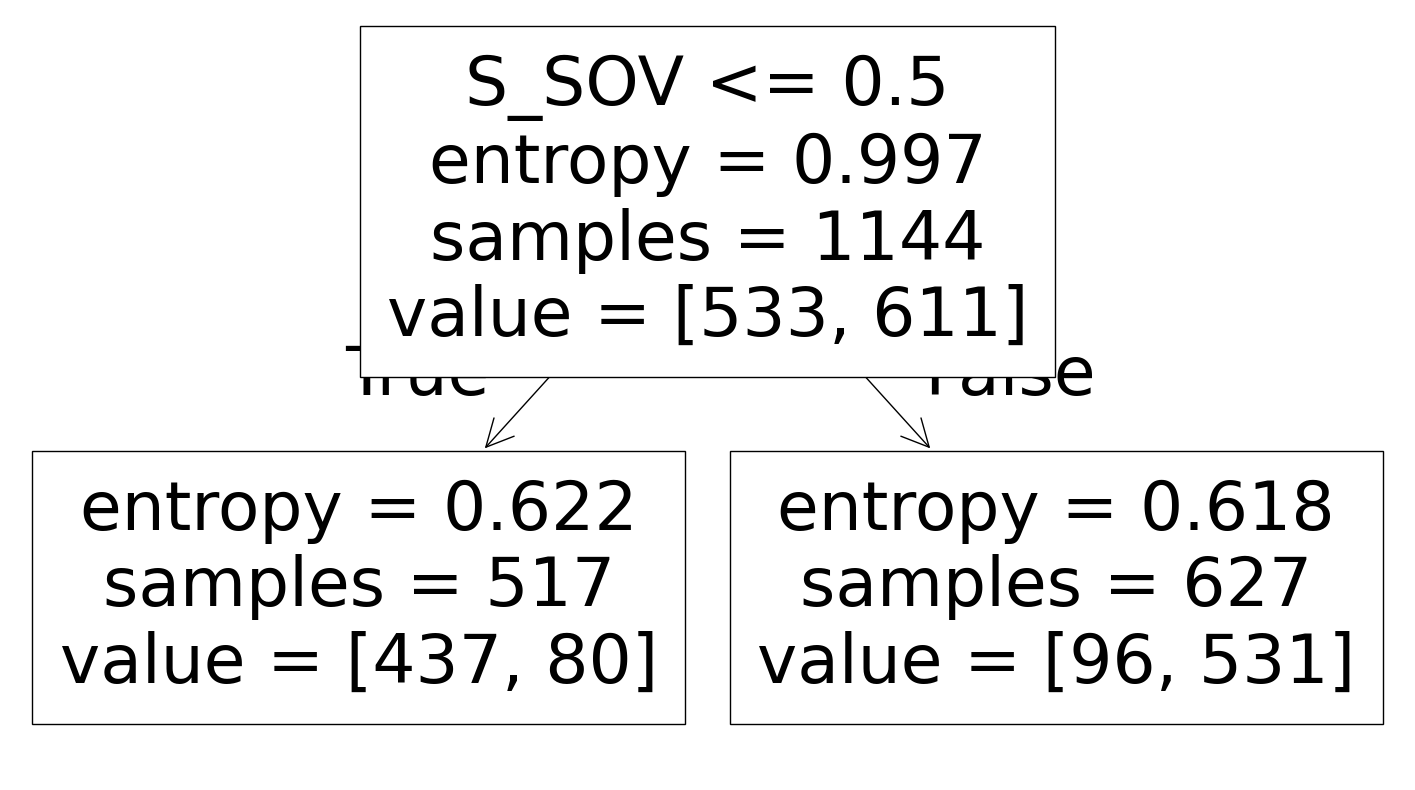

Decision tree for predicting HAS_CASE_SYSTEM
Results of the rule
total languages    1560.00
incomparable          0.00
correct             994.00
incorrect           566.00
tp                  476.00
fp                  436.00
tn                  518.00
fn                  130.00
accuracy              0.64
Name: HAS_CASE_SYSTEM, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.64 / 0.56
Related Greenberg rules
Rule 41: If in a language the verb follows both the nominal subject and nominal object as the dominant order, the language almost always has a case system.


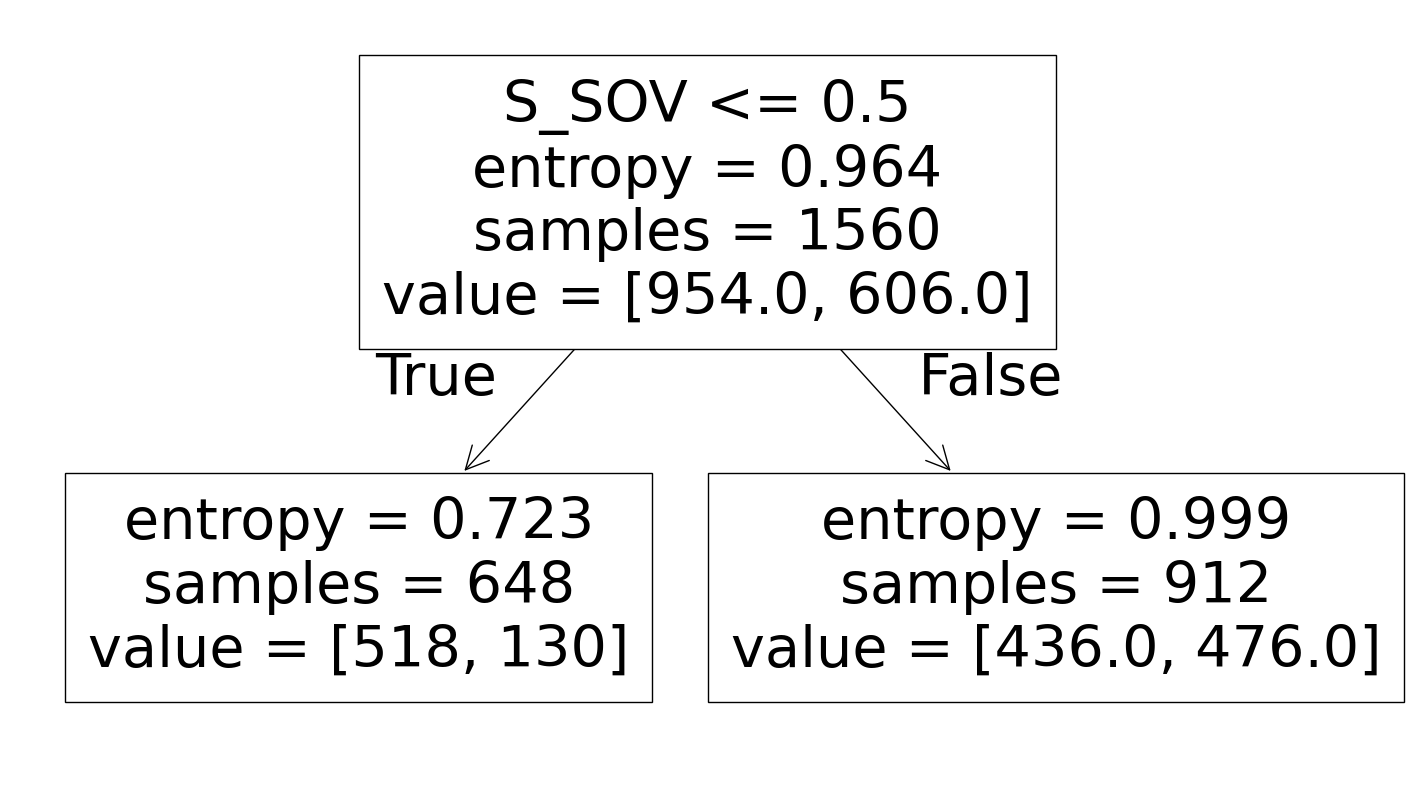

In [181]:
for key in models:
    print(f"Decision tree for predicting {key}")
    plt.figure(figsize=(18, 10))
    tree.plot_tree(models[key], feature_names=x_attributes[key])
    print("Results of the rule")
    print(results_decision_tree_comp_df.loc[key])
    print(f"Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: {results_decision_tree_comp_df.loc[key]["accuracy"]} / {results_rule_based_comp_df.loc[key]["accuracy"]}")
    print("Related Greenberg rules")
    for value in str({results_rule_based_comp_df.loc[key]["Rule mapping"]}).split(","):
        print(f"Rule {value.strip("{}'")}: {greenberg_rules[value.strip("{}'").strip(" ")]}")
    plt.show()

Conclusions

The rules created by the decision tree were (Note: The positions was considered as binary, e.g. if an adjective wasn't before a noun, it was considered to be after. There are however cases where this is not true):
1. When adjective is after noun, then demonstrative word is after noun. <br> 
   Correct: 511, Incorrect: 252
3. When adjective is before noun, then the demonstrative word is before noun <br> 
   Correct: 314, Incorrect: 49
4. When adjective is before noun, then numeral is before noun <br> 
   Correct: 247, Incorrect: 48
5. When adjective is after noun, then numeral is after nount <br> 
   Correct: 607, Incorrect: 222
6. When adposition is after noun, then the possesor is after noun <br> 
   Correct: 447, Incorrect: 283
7. When adposition is before noun, then possesor is before noun <br> 
   Correct: 470, Incorrect: 16
8. When word order is not SOV, then adposition comes before noun <br> 
   Correct: 460:
   Incorrect: 57
9. When word order is SOV, then adposition is after noun <br> 
   Correct: 525
   Incorrect: 102
10. When demonstrative word is after noun, then adjective is after noun <br> 
   Correct: 505
   Incorrect: 30
11. When demonstrative word is before noun, then adjective is after noun <br> 
    Correct: 447
    Incorrect: 332
12. When demonstrative word is after noun, then adjective is after noun <br> 
    Correct: 489
    Incorrect: 46
13. When demonstrative word is before noun, then adjective is before noun <br> 
    Correct: 418
    Incorrect: 361
14. When adjective is after noun, then demonstrative word is after noun <br> 
    Correct: 535
    Incorrect: 228
15. When adjective is before noun, then demonstrative word is before noun <br> 
    Correct: 317
    Incorrect: 46
16. When adjective is after noun, then numeral is after noun <br> 
    Correct: 534
    Incorrect: 228
17. When adjective is before noun, then numeral is before noun <br> 
    Correct: 305
    Incorrect: 57
18. When word order is not SOV, then adposition is before noun <br> 
    Correct: 437
    Incorrect: 80
19. When word order is SOV, then adposition is after noun <br> 
    Correct: 531
    Incorrect: 96
20. When word order is not SOV, then the language has no case system <br> 
    Correct: 518
    Incorrect: 130
21. When word order is SOV, then the language has a case system <br> 
    Correct: 476
    Incorrect: 436